# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading Using Ensemble Strategy


<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [ ]:
!pip install setuptools==64.0.2
!apt-get install swig
!pip install wrds
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git
!pip install alpaca-py
!pip install alpaca


<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

<a id='1.4'></a>
## 2.4. Create Folders

In [4]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [5]:
print(DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [6]:
TRAIN_START_DATE = '2009-04-01'
TRAIN_END_DATE = '2021-01-01'
TEST_START_DATE = '2021-01-01'
TEST_END_DATE = '2022-06-01'

df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = DOW_30_TICKER).fetch_data()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Shape of DataFrame:  (96942, 8)


In [7]:
df.head()

,date,open,high,low,close,volume,tic,day
0,2009-04-01,3.717500,3.892857,3.710357,3.286317,589372000,AAPL,2
1,2009-04-01,48.779999,48.930000,47.099998,34.743179,10850100,AMGN,2
2,2009-04-01,13.340000,14.640000,13.080000,11.563841,27701800,AXP,2
3,2009-04-01,34.520000,35.599998,34.209999,26.850746,9288800,BA,2
4,2009-04-01,27.500000,29.520000,27.440001,19.333210,15308300,CAT,2


In [8]:
df.tail()

,date,open,high,low,close,volume,tic,day
96937,2022-05-31,503.619995,504.109985,495.660004,482.750214,4003100,UNH,1
96938,2022-05-31,210.380005,214.350006,209.110001,209.267395,9586400,V,1
96939,2022-05-31,51.259998,51.560001,50.849998,45.635307,25016600,VZ,1
96940,2022-05-31,43.480000,44.270000,43.049999,39.490406,8192000,WBA,1
96941,2022-05-31,42.486668,43.299999,42.473331,41.749256,36912300,WMT,1


In [9]:
df.shape

(96942, 8)

In [10]:
df.sort_values(['date','tic']).head()

,date,open,high,low,close,volume,tic,day
0,2009-04-01,3.717500,3.892857,3.710357,3.286317,589372000,AAPL,2
1,2009-04-01,48.779999,48.930000,47.099998,34.743179,10850100,AMGN,2
2,2009-04-01,13.340000,14.640000,13.080000,11.563841,27701800,AXP,2
3,2009-04-01,34.520000,35.599998,34.209999,26.850746,9288800,BA,2
4,2009-04-01,27.500000,29.520000,27.440001,19.333210,15308300,CAT,2


In [11]:
len(df.tic.unique())

30

In [12]:
df.tic.value_counts()

tic
AAPL    3315
AMGN    3315
WMT     3315
WBA     3315
VZ      3315
V       3315
UNH     3315
TRV     3315
PG      3315
NKE     3315
MSFT    3315
MRK     3315
MMM     3315
MCD     3315
KO      3315
JPM     3315
JNJ     3315
INTC    3315
IBM     3315
HON     3315
HD      3315
GS      3315
DIS     3315
CVX     3315
CSCO    3315
CRM     3315
CAT     3315
BA      3315
AXP     3315
DOW      807
Name: count, dtype: int64

# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [13]:
 INDICATORS = ['macd',
               'rsi_30',
               'cci_30',
               'dx_30']

In [14]:
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = False)

processed = fe.preprocess_data(df)
processed = processed.copy()
processed = processed.fillna(0)
processed = processed.replace(np.inf,0)

Successfully added technical indicators
Successfully added turbulence index


In [15]:
processed.sample(5)

,date,open,high,low,close,volume,tic,day,macd,rsi_30,cci_30,dx_30,turbulence
9489,2010-07-20,22.270000,23.080000,22.049999,15.759046,66161600,CSCO,1,-0.013342,47.687587,-0.457840,9.975690,78.677216
88239,2021-05-03,133.369995,134.449997,132.589996,128.768723,5053000,NKE,0,-0.939921,48.300601,9.666310,8.906097,20.080580
73202,2019-04-11,55.930000,55.950001,55.310001,48.077118,13186000,CSCO,3,1.116003,68.711995,124.956291,45.575866,32.055526
44760,2015-05-19,33.360001,33.380001,32.990002,26.070456,21867100,INTC,1,0.231064,52.929710,118.872498,4.146784,87.071869
6016,2010-01-27,20.000000,20.330000,19.820000,13.241737,74926200,INTC,2,0.031560,50.728704,-45.730655,21.924305,0.000000


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

In [16]:
stock_dimension = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 29, State Space: 175


In [17]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001, 
    "sell_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4,
    "print_verbosity":5
    
}

<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

* In this notebook, we are training and validating 3 agents (A2C, PPO, DDPG) using Rolling-window Ensemble Method ([reference code](https://github.com/AI4Finance-LLC/Deep-Reinforcement-Learning-for-Automated-Stock-Trading-Ensemble-Strategy-ICAIF-2020/blob/80415db8fa7b2179df6bd7e81ce4fe8dbf913806/model/models.py#L92))

In [18]:
rebalance_window = 63  # rebalance_window is the number of days to retrain the model
validation_window = 63  # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)

ensemble_agent = DRLEnsembleAgent(df=processed,
                 train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                 val_test_period=(TEST_START_DATE,TEST_END_DATE),
                 rebalance_window=rebalance_window, 
                 validation_window=validation_window, 
                 **env_kwargs)



In [19]:
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.005,
                    'learning_rate': 0.0007
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2, #2048
                    "learning_rate": 0.00025,
                    "batch_size": 128
                    }

DDPG_model_kwargs = {
                      #"action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 1, #10_000
                      "learning_rate": 0.0005,
                      "batch_size": 64
                    }

timesteps_dict = {'a2c' : 1, #10_000 each
                 'ppo' : 1, 
                 'ddpg' : 1
                 }

In [20]:
df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
                                                 PPO_model_kwargs,
                                                 DDPG_model_kwargs,
                                                 timesteps_dict)

============Start Ensemble Strategy============
turbulence_threshold:  203.40286192835106
======Model training from:  2009-04-01 to  2021-01-04
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0007}
Using cuda device
Logging to tensorboard_log/a2c/a2c_126_11
======A2C Validation from:  2021-01-04 to  2021-04-06
A2C Sharpe Ratio:  0.29181419928941904
======PPO Training========
{'ent_coef': 0.01, 'n_steps': 2, 'learning_rate': 0.00025, 'batch_size': 128}
Using cuda device
Logging to tensorboard_log/ppo/ppo_126_11
------------------------------------
| time/              |             |
|    fps             | 77          |
|    iterations      | 1           |
|    time_elapsed    | 0           |
|    total_timesteps | 2           |
| train/             |             |
|    reward          | 0.023613973 |
------------------------------------
======PPO Validation from:  2021-01-04 to  2021-04-06
PPO Sharpe Ratio:  0.3401578159066021
======DDPG Training========

In [21]:
df_summary

,Iter,Val Start,Val End,Model Used,A2C Sharpe,PPO Sharpe,DDPG Sharpe
0,126,2021-01-04,2021-04-06,DDPG,0.291814,0.340158,0.45244
1,189,2021-04-06,2021-07-06,DDPG,0.078038,-0.013,0.113362
2,252,2021-07-06,2021-10-04,DDPG,-0.127185,-0.146748,0.01166
3,315,2021-10-04,2022-01-03,A2C,0.19152,0.023545,0.189024


<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [22]:
unique_trade_date = processed[(processed.date > TEST_START_DATE)&(processed.date <= TEST_END_DATE)].date.unique()

In [23]:

# Assuming unique_trade_date, rebalance_window, and validation_window are defined

df_trade_date = pd.DataFrame({'datadate': unique_trade_date})

df_account_value_list = []
for i in range(rebalance_window + validation_window, len(unique_trade_date) + 1, rebalance_window):
    temp = pd.read_csv(f'results/account_value_trade_ensemble_{i}.csv')
    df_account_value_list.append(temp)

# Concatenate all DataFrames from the list
df_account_value = pd.concat(df_account_value_list, ignore_index=True)

# Ensure account_value is numeric and calculate Sharpe Ratio
df_account_value['account_value'] = pd.to_numeric(df_account_value['account_value'], errors='coerce')
sharpe = (252**0.5) * df_account_value['account_value'].pct_change(1).mean() / df_account_value['account_value'].pct_change(1).std()
print('Sharpe Ratio: ', sharpe)

# Ensure alignment of DataFrames before join
if len(df_account_value) == len(df_trade_date[validation_window:].reset_index(drop=True)):
    df_account_value = df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))
else:
    print("Warning: Lengths of df_account_value and df_trade_date do not match.")


Sharpe Ratio:  0.8077376370503959


In [24]:
df_account_value.head()

,account_value,date,daily_return
0,1.000000e+06,2021-04-06,NaN
1,9.998343e+05,2021-04-07,-0.000166
2,1.000827e+06,2021-04-08,0.000993
3,1.006059e+06,2021-04-09,0.005228
4,1.004097e+06,2021-04-12,-0.001950


In [25]:
print(df_account_value.columns)

Index(['account_value', 'date', 'daily_return'], dtype='object')


<Axes: >

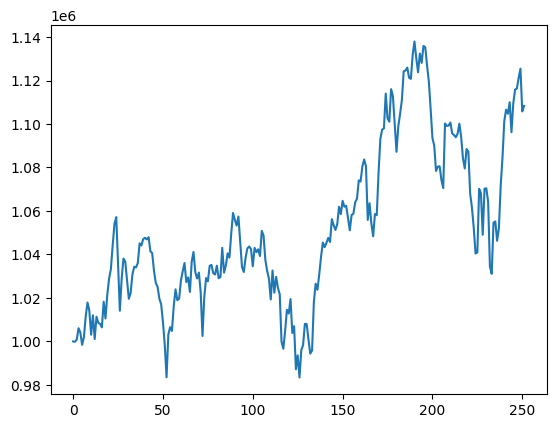

In [26]:
%matplotlib inline
df_account_value.account_value.plot()

In [27]:
df_account_value['date'] = pd.to_datetime(df_account_value['date'])
print(df_account_value['date'].dtypes)

datetime64[ns]


<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [28]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
Annual return          0.108287
Cumulative returns     0.108287
Annual volatility      0.139881
Sharpe ratio           0.807738
Calmar ratio           1.153271
Stability              0.529501
Max drawdown          -0.093896
Omega ratio            1.142776
Sortino ratio          1.193278
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.144742
Daily value at risk   -0.017175
dtype: float64


In [29]:
#baseline stats
print("==============Get Baseline Stats===========")
df_account_value.columns = df_account_value.columns.str.strip()
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========


[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (251, 8)
Annual return          0.037486
Cumulative returns     0.037335
Annual volatility      0.134331
Sharpe ratio           0.342028
Calmar ratio           0.331049
Stability              0.066383
Max drawdown          -0.113235
Omega ratio            1.058031
Sortino ratio          0.480831
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.970301
Daily value at risk   -0.016742
dtype: float64


<a id='6.2'></a>
## 7.2 BackTestPlot

[*********************100%%**********************]  1 of 1 completed

==============Compare to DJIA===========
Shape of DataFrame:  (251, 8)


Start date,2021-04-06
End date,2022-04-01
Total months,12
,Backtest
Annual return,10.829%
Cumulative returns,10.829%
Annual volatility,13.988%
Sharpe ratio,0.81
Calmar ratio,1.15
Stability,0.53
Max drawdown,-9.39%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,9.39,2022-01-04,2022-03-08,NaT,NaN
1,7.15,2021-08-11,2021-10-04,2021-11-03,61
2,6.97,2021-05-10,2021-06-18,2021-08-11,68
3,3.26,2021-11-23,2021-12-01,2021-12-07,11
4,2.58,2021-12-15,2021-12-20,2021-12-27,9


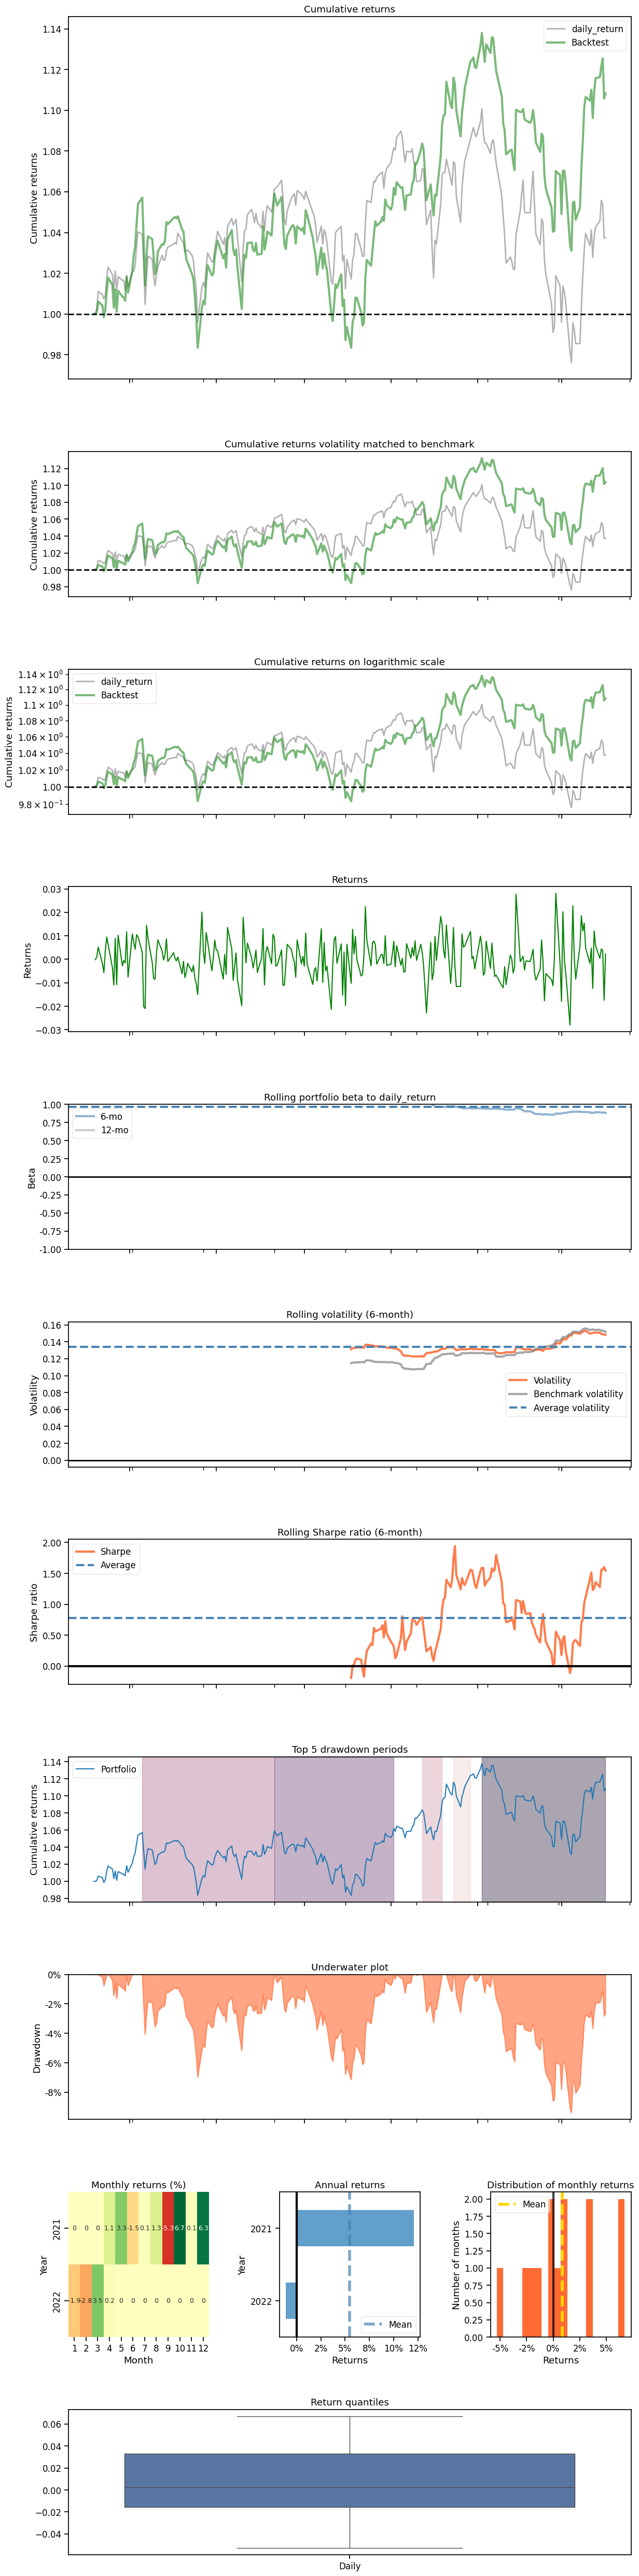

In [30]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
              baseline_ticker = '^DJI', 
              baseline_start = df_account_value.loc[0,'date'],
              baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])

In [31]:
from alpaca.data import CryptoHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest
from alpaca.data.timeframe import TimeFrame
import datetime as datetime
from alpaca.data.live import StockDataStream
from alpaca.trading.client import TradingClient
from alpaca.trading.requests import MarketOrderRequest
from alpaca.trading.enums import OrderSide, TimeInForce
from alpaca.trading.requests import LimitOrderRequest


# # paper=True enables paper trading
trading_client = TradingClient('YOUR ALPACA KEY', 'YOUR ALPACA SECRET KEY', paper=True)


# preparing orders
market_order_data = MarketOrderRequest(
                    symbol="NVDA",
                    qty=1,
                    side=OrderSide.BUY,
                    time_in_force=TimeInForce.DAY
                    )

# Market order
market_order = trading_client.submit_order(
                order_data=market_order_data
               )

# Calculate Sharpe ratio here as before
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ', sharpe)

# Now, using the 'sharpe' variable
if sharpe > .4:
    market_order = trading_client.submit_order(order_data=market_order_data)
else:
    print("No trades for today")


print("Please check your Alpaca dashboard for the order status!")

Sharpe Ratio:  0.8077376370503959
Please check your Alpaca dashboard for the order status!
